In [ ]:
import numpy as np
import math as mh
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
from functools import cmp_to_key

In [ ]:
def H(arr):
  x = arr[0]
  y = arr[1]
  return  2*np.exp(-(((x-3)*(x-3) + (y-3)*(y-3)))) + np.exp(-x*x - y*y)
def S(x):
  return np.exp(-x)

class pdf:
  def __init__(self):
    self.mu = np.array([0.0, 0.0])
    self.sigma = np.array([[ 1, 0], [0,  1]])
    self.PDF =  multivariate_normal(self.mu, self.sigma)

  def f(self,x):
    return self.PDF.pdf(x)

  def update(self,newMu,newSigma):
    self.mu = newMu
    self.sigma = newSigma
    self.sigma[0][1] = self.sigma[1][0] = 0
    self.PDF = multivariate_normal(self.mu,self.sigma)

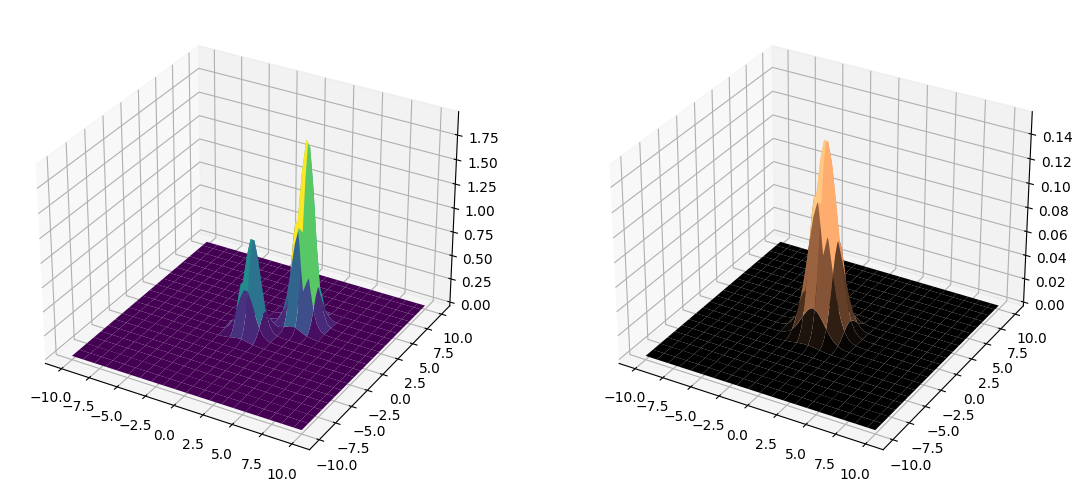

In [ ]:
N = 60
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)
Z = H([X,Y])
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3,
                cmap='viridis', edgecolor='none');

mu = np.array([0.0, 1.0])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

pdf = pdf()


Z =pdf.f(pos)

ax = fig.add_subplot(1,2,2,projection = '3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,
                cmap='copper')

plt.tight_layout()
plt.savefig('two_3d_plots.png')


In [ ]:
def I(x,gamma):
  return x
  if x>=gamma:
    return 1
  return 0

In [ ]:
def calculate_expection(X,func,k,pdf_function,gamma):  #here X is a vector then.
  arr = []
  for x in X:
    y = np.array(x)
    arr.append(func(y,k,pdf_function,gamma))
  arr = np.array(arr)
  # print("Sum Array is given as ->>> ",arr)
  sum = np.sum(arr ,axis = 0)
  # print("Sum is given as ->>> ",sum)
  return np.divide(sum,len(X));

In [ ]:
def update_mu(X,gamma,k,pdf_function):
    # func_numerator = lambda x, k, pdf_function, gamma: I((S(H(x)) ** k) / pdf_function.f(x) , gamma) * x
    func_numerator = lambda x,k,pdf_function,gamma: ((S(H(x)) ** k) / pdf_function.f(x)*(I(H(x),gamma)))*x
    func_denomerator = lambda x, k, pdf_function, gamma: ((S(H(x)) ** k) / pdf_function.f(x))*I(H(x), gamma)
    return calculate_expection(X,func_numerator,k,pdf_function,gamma) / (calculate_expection(X,func_denomerator,k,pdf_function,gamma))

In [ ]:
def update_sigma(X,gamma,k,pdf_function):
  # func_numerator = lambda x, k, pdf_function, gamma: I((S(H(x)) ** k) / pdf_function.f(x) , gamma) * np.matmul(((x - pdf_function.mu)).reshape(2,1),np.transpose((x - pdf_function.mu).reshape(2,1)))
  # func_denominator = lambda x, k, pdf_function, gamma: I((S(H(x)) ** k) / pdf_function.f(x) , gamma)
  func_numerator = lambda x, k, pdf_function, gamma: ( ((S(H(x)) ** k) / pdf_function.f(x)) *I(H(x) ,gamma)) * np.matmul(((x - pdf_function.mu)).reshape(2,1),np.transpose((x - pdf_function.mu).reshape(2,1)))
  func_denominator = lambda x, k, pdf_function, gamma: ((S(H(x)) ** k) / pdf_function.f(x))*I(H(x), gamma)
  arr = calculate_expection(X,func_numerator,k,pdf_function,gamma) / (calculate_expection(X,func_denominator,k,pdf_function,gamma))
  return arr

In [ ]:
def return_random_iids(low,high,N):
  randomIidsX = (np.random.uniform(low[0], high[0], N))
  randomIidsY = (np.random.uniform(low[1], high[1], N))
  randomIids =  []
  for i in range(0,N):
    randomIids.append(np.array([randomIidsX[i],randomIidsY[i]]))
  randomIids = np.array(randomIids)
  return randomIids

In [ ]:
low = np.array([-2,-2])
high = np.array([5, 5])
N = 1000
quantile = 0.08
K = 5
gamma = 0.02
epsilon = 0.1
alpha = 1.5

def gamma_bar(rho,N_points):
  HValues = [H(i) for i in randomIids]
  print(HValues)

  sortedHValues = sorted(HValues)
  quantileIndex = int((1-quantile)*N)
  topQuantile = sortedHValues[quantileIndex:]
  return max(topQuantile)
def compare(X,Y):
  if(X[0]<Y[0]):
     return -1
  return 1
for k in range(1,K+1):
  randomIids = return_random_iids(low,high,N)
  HValues = [H(i) for i in randomIids]
  HValues_X = [[H(i),i] for i in randomIids]
  sortedHValues = sorted(HValues)
  sortedXValues = sorted(HValues_X,key=cmp_to_key(compare))
  XArray = [temp_arr[1] for temp_arr in sortedXValues]
  quantileIndex = int((1-quantile)*N)
  currGamma   = sortedHValues[quantileIndex]
  print("currGamma--> ",currGamma)
  if k == 1 or currGamma >= gamma+(epsilon/2):
    gamma = currGamma
    ind = HValues.index(gamma)
    # low = randomIids[ind]
  else:
    gamma = currGamma
    N = int(alpha*N)
  print("What is Xarray--> ",XArray)
  print("HValues_X ---> ",sortedXValues)
  print("gamma--> ",gamma)
  print("Low values--> ",low)
  print("H(low values) ",H(low))
  print(update_mu(XArray,gamma,k,pdf),H(update_mu(XArray,gamma,k,pdf)))
  print(update_sigma(XArray,gamma,k,pdf))
  pdf.update(update_mu(XArray,gamma,k,pdf),update_sigma(XArray,gamma,k,pdf))
  # print("currGamma: ", currGamma)

print(pdf.mu,pdf.sigma)


currGamma-->  0.7382272748863455
What is Xarray-->  [array([ 4.6199679 , -1.97964542]), array([ 4.64779322, -1.92542888]), array([-1.76815414,  4.72936222]), array([ 4.82332702, -1.58973509]), array([ 4.8314519 , -1.55217425]), array([ 4.48368042, -1.64594867]), array([-1.95810645,  4.28936672]), array([ 4.92020926, -1.330023  ]), array([ 4.50850231, -1.49056265]), array([ 4.68052797, -1.38850947]), array([ 4.43269393, -1.52718794]), array([-1.24648941,  4.8966742 ]), array([ 4.22178501, -1.75522769]), array([-1.19721836,  4.95388506]), array([ 4.17864323, -1.7777948 ]), array([-1.74888516,  4.18625007]), array([ 4.30112672, -1.52339635]), array([-1.20912581,  4.52535138]), array([-1.13520624,  4.6898416 ]), array([-1.23801028,  4.43824663]), array([-1.21486498,  4.44151865]), array([ 3.99792645, -1.7336122 ]), array([-1.18269222,  4.45530556]), array([-1.52490805,  4.03087265]), array([-1.37632449,  4.0961378 ]), array([ 4.9264281 , -0.91176979]), array([-1.99884546,  3.75589963]), ar

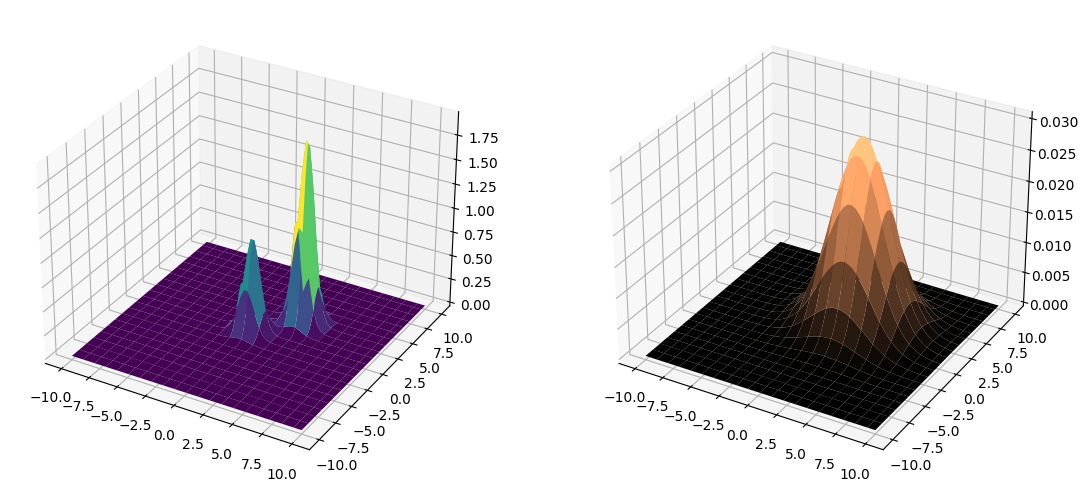

In [ ]:
N = 60
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)
Z = H([X,Y])
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3,
                cmap='viridis', edgecolor='none');

mu = np.array([0.0, 1.0])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


Z =pdf.f(pos)

ax = fig.add_subplot(1,2,2,projection = '3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,
                cmap='copper')



plt.tight_layout()
plt.savefig('two_3d_final.png')